# Modelo de OneClassSVM entrenado con 2F de datos Astro, y predicción sobre datos Unid (no identificados)

**Proyecto**: Detección de posibles fuentes de materia oscura usando ML en datos Fermi-LAT  
**Autor**: Marta Canino Romero  
**Fecha**: febrero-mayo 20225

---

## Descripción:

Este notebook aplica un modelo **One-Class SVM** entrenado con datos de fuentes astrofísicas conocidas (ASTRO) usando las siguientes características:

- E_peak
- beta

Este modelo se entrena para identificar anomalías que puedan corresponder a posibles fuentes de materia oscura (UNIDs) en los datos no identificados del catálogo 4FGL.

---

## Objetivos específicos:

- Entrenar modelo OCSVM con [número de features] 
- Optimizar hiperparámetros (grid search sobre `nu` y `gamma`)
- Evaluar sobre datos de validación y prueba
- Aplicar modelo final sobre datos UNID para predicción

---

## Entrada de datos:

- `../data/astro_df.txt`

In [1039]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score


In [1040]:
# Cargar dataset
data_path = "../data/astro_df.txt"
df_astro = pd.read_csv(data_path, sep='\s+')

df_astro = df_astro.rename(columns={"0,1=astro,DM": "class"})
# --- Comprobamos distribución del dataset ---
print(f" Dataset cargado. Forma: {df_astro.shape}")
print(f" Nombres de las columnas: {list(df_astro.columns)}")

df_astro.head()

 Dataset cargado. Forma: (2831, 5)
 Nombres de las columnas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'astro_DM']


,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),astro_DM
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [1041]:
# --- Selección de características ---
features = ['Log(E_peak)', 'Log(beta)']
target = 'astro_DM'

print(f"Features seleccionadas: {features}")
print(f"Columna objetivo: {target}")

# --- Comprobamos valores nulos ---
print("\n Valores faltantes por columna:")
print(df_astro[features + [target]].isnull().sum())

print("\n Muestra del dataset:")
display(df_astro[features + [target]].head())

Features seleccionadas: ['Log(E_peak)', 'Log(beta)']
Columna objetivo: astro_DM

 Valores faltantes por columna:
Log(E_peak)    0
Log(beta)      0
astro_DM       0
dtype: int64

 Muestra del dataset:


,Log(E_peak),Log(beta),astro_DM
0,-0.412502,-1.325139,0.0
1,0.708140,-0.000174,0.0
2,0.224740,-0.581202,0.0
3,0.257319,-0.561933,0.0
4,0.326110,-1.100179,0.0


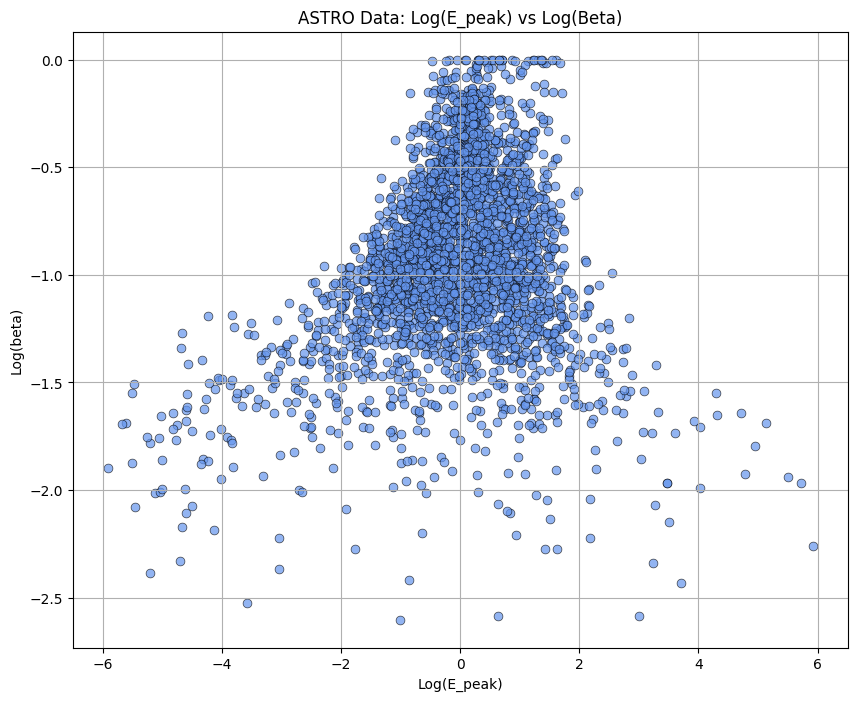

In [1042]:
# Comprobamos la distribución de los datos astro antes de escalar
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=df_astro,
    x="Log(E_peak)",
    y="Log(beta)",
    color="cornflowerblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)

plt.title("ASTRO Data: Log(E_peak) vs Log(Beta)")
plt.xlabel("Log(E_peak)")
plt.ylabel("Log(beta)")
plt.grid(True)
plt.show()

In [1043]:
X = df_astro[features].values
y = df_astro[target].values

# SPLIT: Train / Val / Test
# 60% train, 20% val, 20% test
# de esta manera, el test set no se ve en el entrenamiento
# y el val set se usa para ajustar los hiperparámetros)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Escalamos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


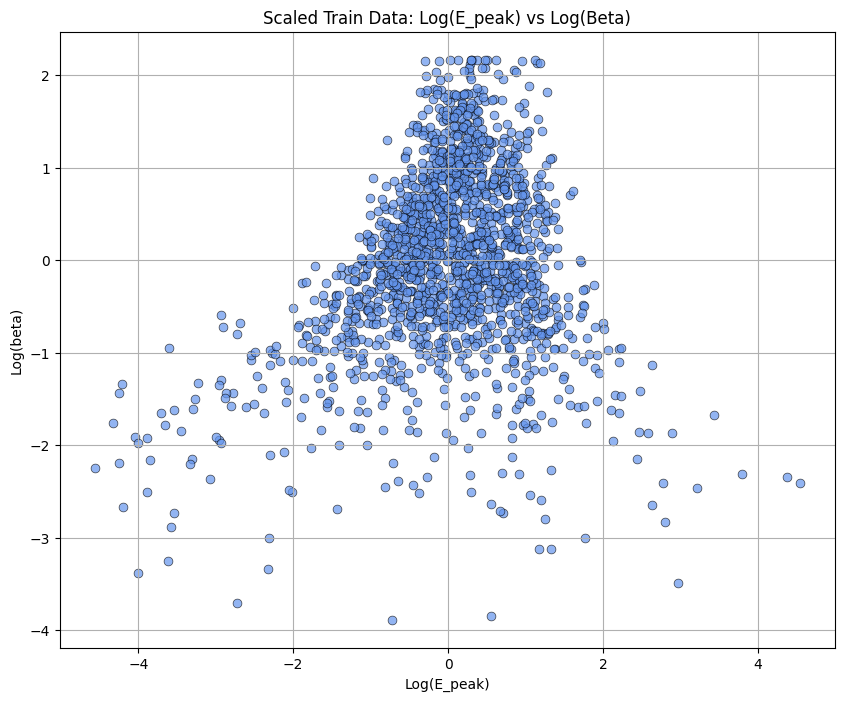

In [1044]:
# Comprobamos que los datos están bien escalados
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=X_train_scaled[:, 0],
    y=X_train_scaled[:, 1],
    color="cornflowerblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)
plt.title("Scaled Train Data: Log(E_peak) vs Log(Beta)")
plt.xlabel("Log(E_peak)")
plt.ylabel("Log(beta)")
plt.grid(True)
plt.show()


In [1045]:
# Hiperparámetros a explorar
nu_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]
# gamma_values = ['scale', 'auto'] + list(np.logspace(-4, 2, 7))
# gamma_values = ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]
# gamma_values = ['scale', 'auto'] + list(np.logspace(-3, 1, 5))
gamma_values = [0.1]

# Tracking
results = []
best_outliers = np.inf
best_model = None
best_params = {}

print("Buscando hiperparámetros que minimicen outliers en ASTRO (validación)...")

for nu in nu_values:
    for gamma in gamma_values:
        model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        model.fit(X_train_scaled)

        preds_val = model.predict(X_val_scaled)  # 1 = normal, -1 = outlier
        pred_labels = np.where(preds_val == 1, 0, 1)         # Mapear a 0 = normal, 1 = anomalía
        true_labels = y_val.astype(int)                  # Aseguramos tipo int
        n_outliers = np.sum(preds_val == -1)
        # f1 = f1_score(true_labels, pred_labels, pos_label=0)

        results.append({'nu': nu, 'gamma': gamma, 'val_outliers': n_outliers})

        """
        if f1 > best_score:
            best_score = f1
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}
        """
        if n_outliers < best_outliers:
            best_outliers = n_outliers
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}

# Mostrar resultado óptimo
print(f"\n Mejor combinación de hiperparámetros:")
print(f"   - ν = {best_params['nu']}")
print(f"   - γ = {best_params['gamma']}")
print(f"Outliers (val set): {best_outliers} de {len(X_val_scaled)} muestras")

# Convertir a DataFrame si quieres visualizar todo el grid
df_results = pd.DataFrame(results)
display(df_results.sort_values(by='val_outliers'))

Buscando hiperparámetros que minimicen outliers en ASTRO (validación)...

 Mejor combinación de hiperparámetros:
   - ν = 0.001
   - γ = 0.1
Outliers (val set): 3 de 566 muestras


,nu,gamma,val_outliers
0,0.001,0.1,3
1,0.002,0.1,3
2,0.005,0.1,4
3,0.010,0.1,8
4,0.020,0.1,19
5,0.050,0.1,36


In [1046]:
# Evaluar el modelo en el conjunto de validación
val_preds = best_model.predict(X_val_scaled)
n_val_outliers = np.sum(val_preds == -1)
print(f"Outliers (val set): {n_val_outliers} de {len(X_val_scaled)} muestras")

# Evaluar el modelo en el conjunto de test
# (no se ha visto en el entrenamiento)
test_preds = best_model.predict(X_test_scaled)
n_test_outliers = np.sum(test_preds == -1)
print(f"Outliers (test set): {n_test_outliers} de {len(X_test_scaled)} muestras")

Outliers (val set): 3 de 566 muestras
Outliers (test set): 6 de 567 muestras


In [1047]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report

# Paso 1: identificar hiperparámetros globales
best_global = df_results.sort_values(by='val_outliers', ascending=True).iloc[0]
print("Mejor combinación global:")
print(best_global)

# Paso 2: reentrenar con X_train + X_val
X_final_train = np.vstack([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

scaler_final = StandardScaler()
X_final_train_scaled = scaler_final.fit_transform(X_final_train)
X_test_scaled = scaler_final.transform(X_test)

# Paso 3: entrenar modelo final
final_model = OneClassSVM(kernel='rbf', nu=best_global['nu'], gamma=best_global['gamma'])
final_model.fit(X_final_train_scaled)

# Paso 4: evaluar en test
test_preds = final_model.predict(X_test_scaled)
test_labels = np.where(test_preds == 1, 0, 1)

# Paso 5: métricas
print("\nEvaluación en el conjunto de test:")
print(f"Outliers (test set): {np.sum(test_preds == -1)} de {len(X_test_scaled)} muestras")
# print(f"F1 Score: {f1_score(y_test, test_labels, pos_label=0):.4f}")
print("\nMatriz de confusión:")
cm = confusion_matrix(y_test, test_labels)
print(cm)
print("\nReporte de clasificación:")
print(classification_report(y_test, test_labels, target_names=unique_labels(y_test, test_labels).astype(str)))

Mejor combinación global:
nu              0.001
gamma           0.100
val_outliers    3.000
Name: 0, dtype: float64

Evaluación en el conjunto de test:
Outliers (test set): 5 de 567 muestras

Matriz de confusión:
[[562   5]
 [  0   0]]

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       567
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99       567
   macro avg       0.50      0.50      0.50       567
weighted avg       1.00      0.99      1.00       567



<Axes: ylabel='Count'>

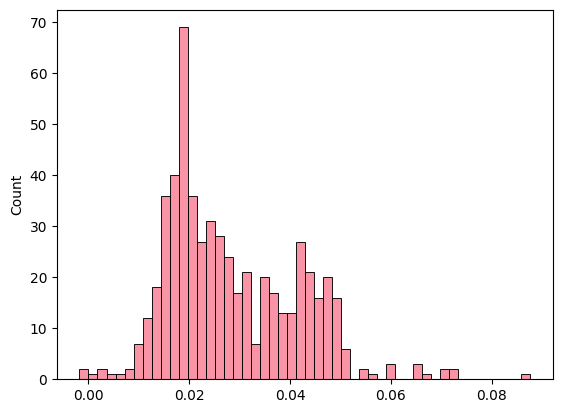

In [1048]:
scores = final_model.decision_function(X_val_scaled)

sns.histplot(scores, bins=50)

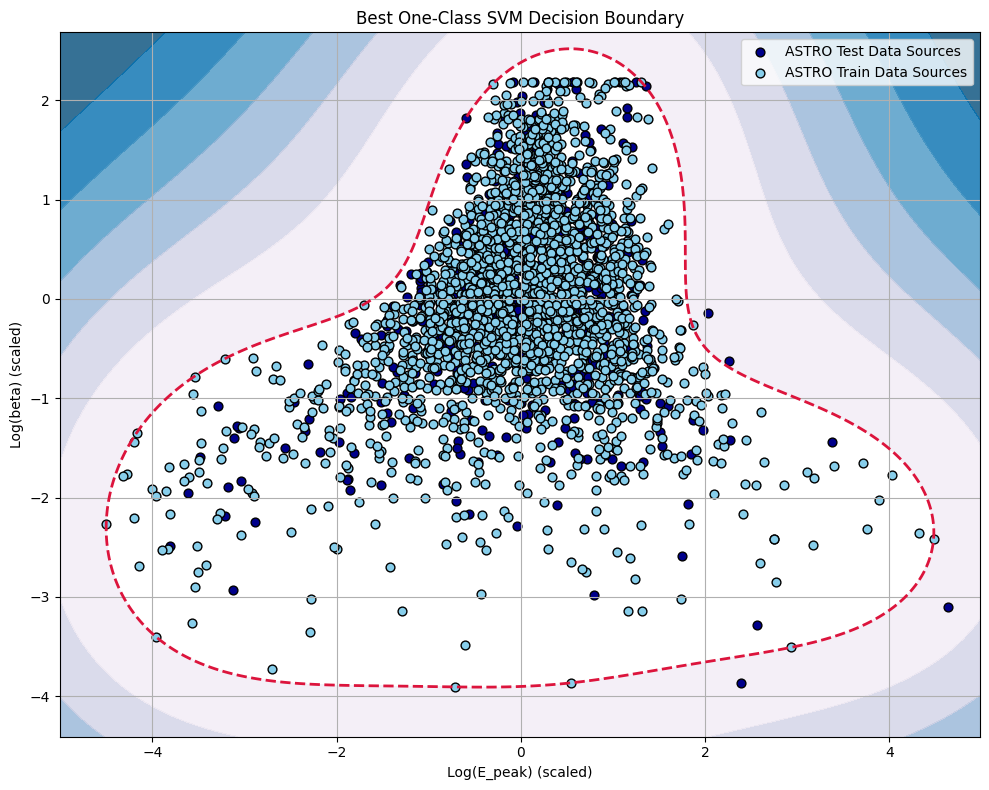

In [1049]:
# Create meshgrid (with correct feature order)
xx, yy = np.meshgrid(
    np.linspace(X_final_train_scaled[:, 0].min() - 0.5, X_final_train_scaled[:, 0].max() + 0.5, 300),  # Log(E_peak)
    np.linspace(X_final_train_scaled[:, 1].min() - 0.5, X_final_train_scaled[:, 1].max() + 0.5, 300)   # Log(beta)
)

grid = np.c_[xx.ravel(), yy.ravel()]

Z = final_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

# Plot training and test data
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c='darkblue', edgecolors='k', s=40, label='ASTRO Test Data Sources')
plt.scatter(X_final_train_scaled[:, 0], X_final_train_scaled[:, 1], c='skyblue', edgecolors='k', s=40, label='ASTRO Train Data Sources')

plt.xlabel("Log(E_peak) (scaled)")
plt.ylabel("Log(beta) (scaled)")
plt.title("Best One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


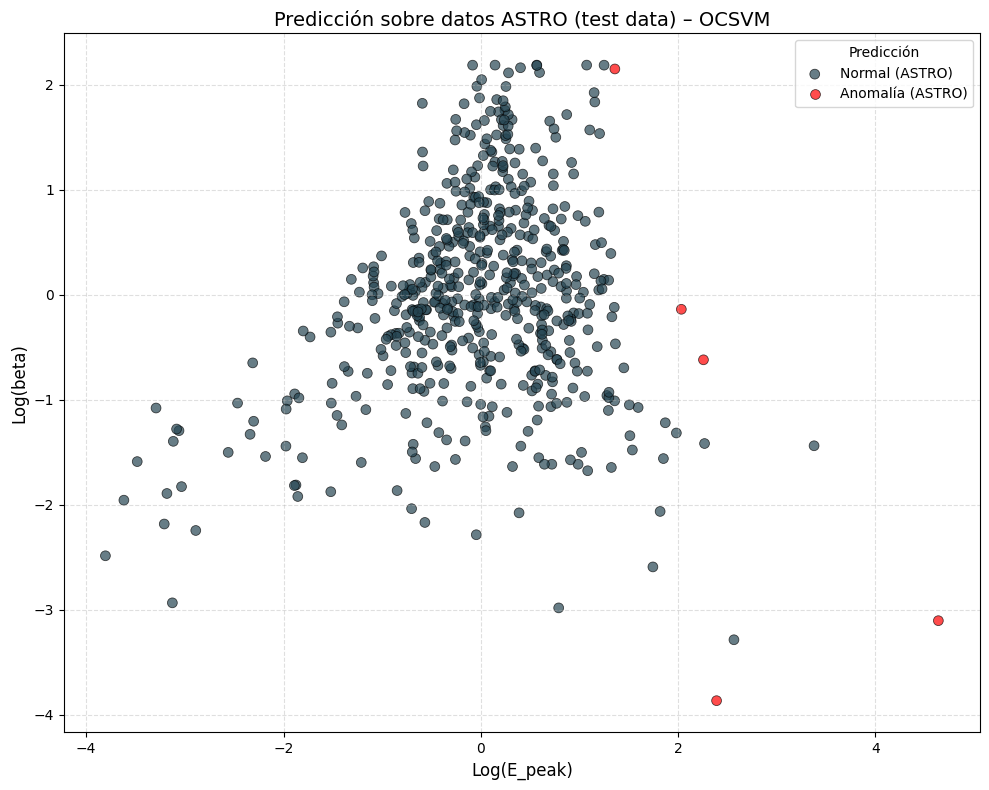

In [1050]:
plt.figure(figsize=(10, 8))

# Colores mejorados
palette = {
    1: '#264653',   # ASTRO normal (azul petróleo)
    -1: 'red'   # ASTRO outlier (rojo)
}

sns.scatterplot(
    x=X_test_scaled[:, 0],
    y=X_test_scaled[:, 1],
    hue=test_preds,
    palette=palette,
    edgecolor='k',
    alpha=0.7,
    s=50,
    marker='o'
)

plt.title("Predicción sobre datos ASTRO (test data) – OCSVM", fontsize=14)
plt.xlabel("Log(E_peak)", fontsize=12)
plt.ylabel("Log(beta)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(
    title="Predicción",
    loc='upper right',
    labels=["Normal (ASTRO)", "Anomalía (ASTRO)"],
    fontsize=10
)
plt.tight_layout()
plt.show()


# Predict on UNIDs

In [1051]:
# unids_path = "../../data/raw/unids_3F_beta_err_names.txt"
unids_path = "../data/unids_log.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')
df_unids.head()

,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),number
0,0.400175,-1.047208,0.869208,0.212452,0
1,0.169733,-0.380594,0.733598,-0.113037,1
2,0.203142,-0.168578,1.033058,-0.430366,2
3,-0.031074,-0.557363,0.881133,-0.201588,3
4,-0.351835,-0.493901,0.630916,-0.246028,4


In [1052]:
# Extraer y escalar 
X_unids_log = df_unids[["Log(E_peak)", "Log(beta)"]].values
X_unids_scaled = scaler.transform(X_unids_log)

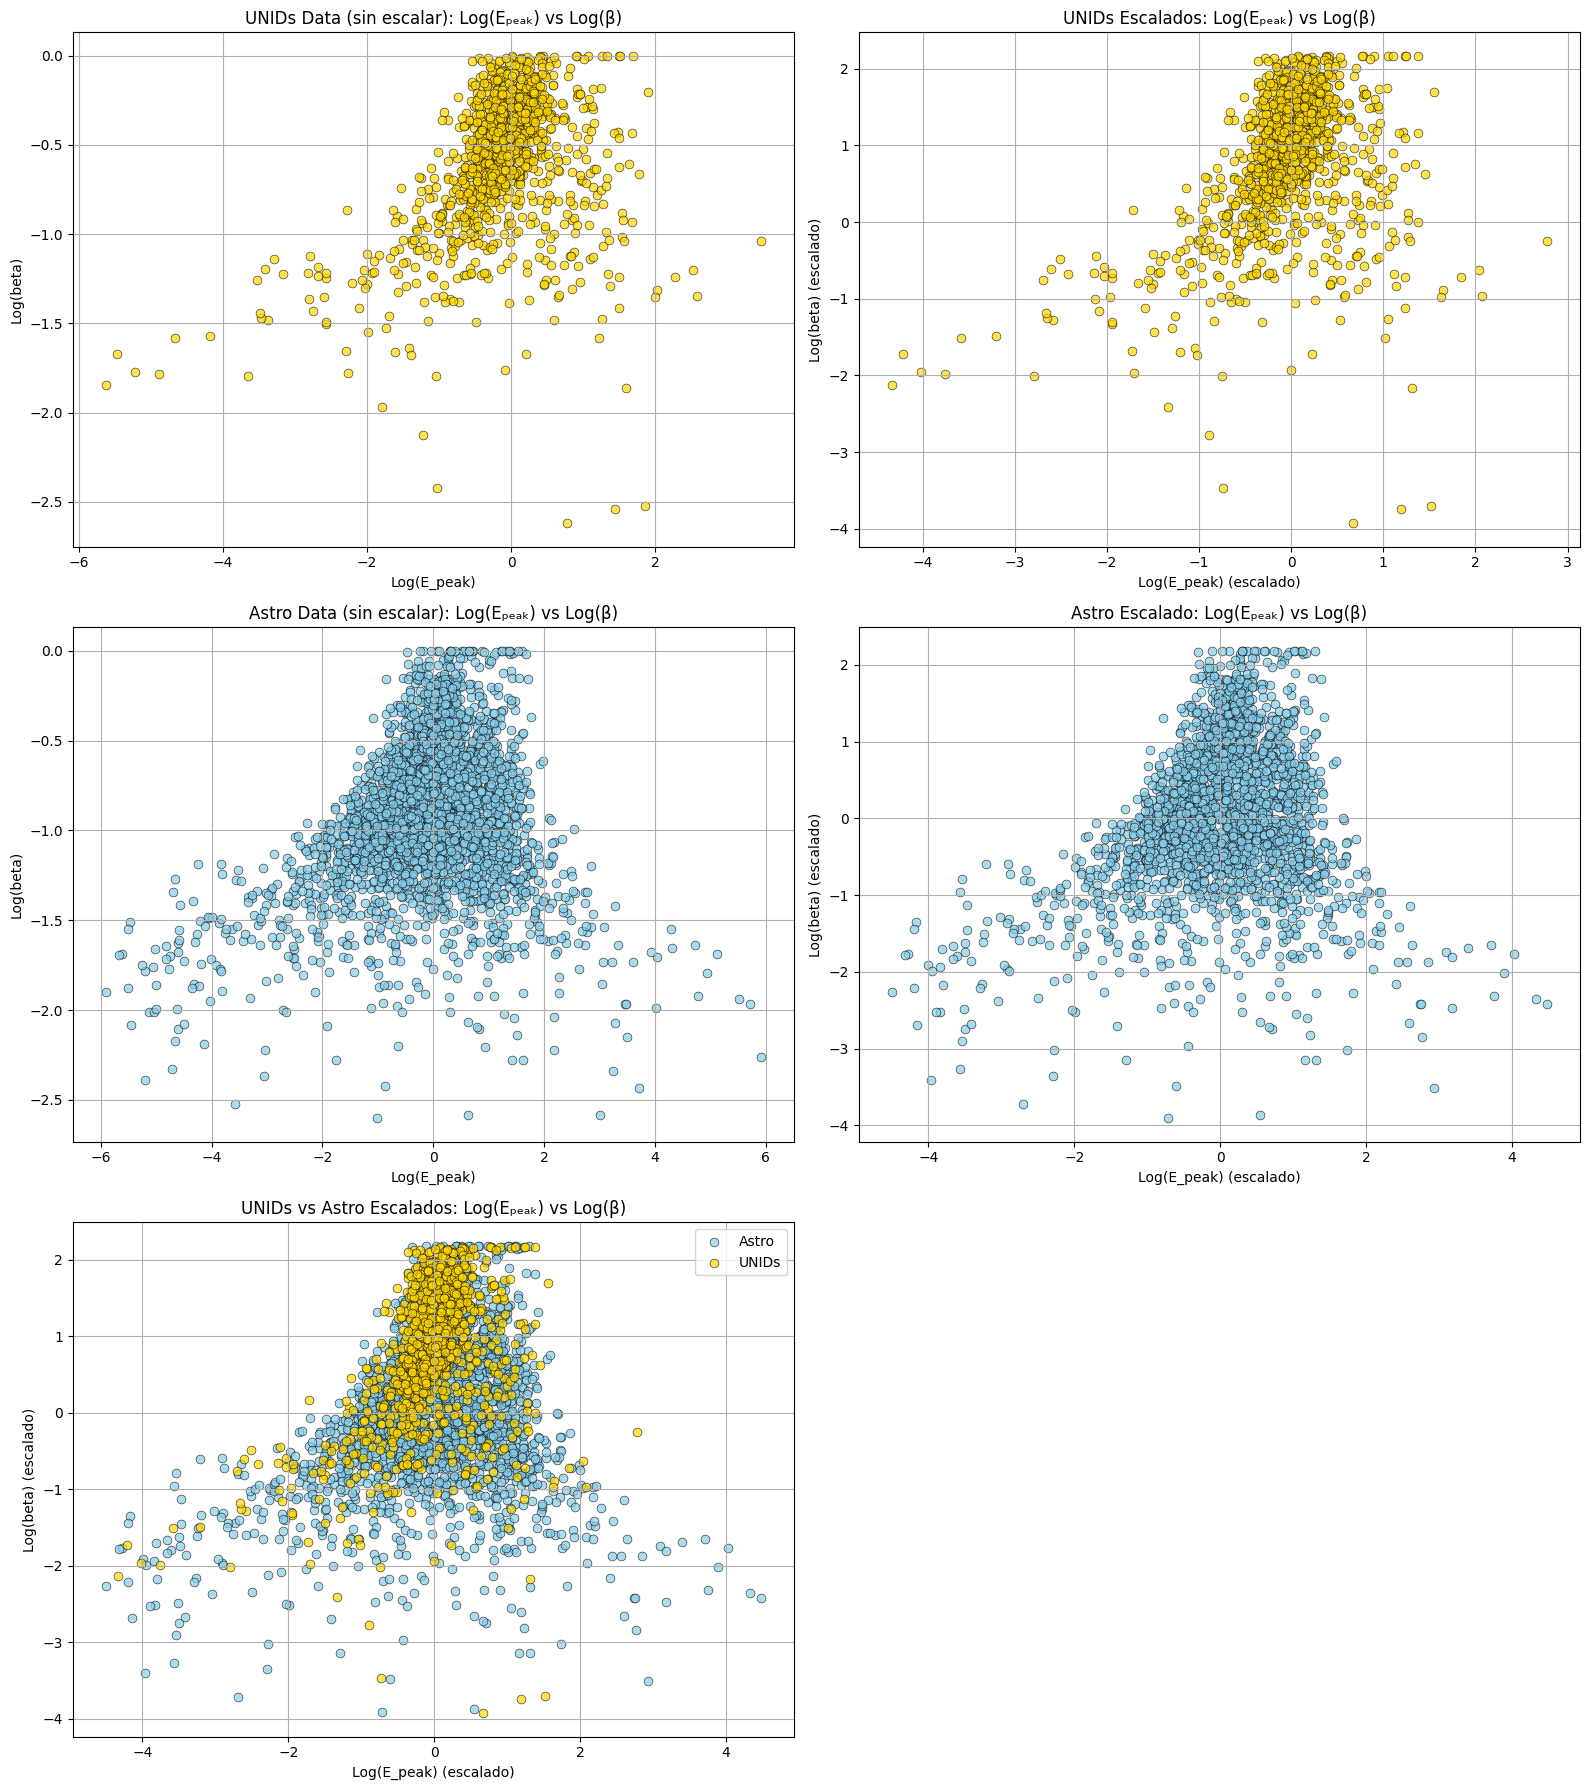

In [1053]:
# --- Crear subplots 3x2 ---
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# --- Plot 1: UNIDs sin escalar ---
sns.scatterplot(
    data=df_unids,
    x="Log(E_peak)",
    y="Log(beta)",
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[0, 0]
)
axes[0, 0].set_title("UNIDs Data (sin escalar): Log(Eₚₑₐₖ) vs Log(β)")
axes[0, 0].set_xlabel("Log(E_peak)")
axes[0, 0].set_ylabel("Log(beta)")
axes[0, 0].grid(True)

# --- Plot 2: UNIDs escalados ---
sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[0, 1]
)
axes[0, 1].set_title("UNIDs Escalados: Log(Eₚₑₐₖ) vs Log(β)")
axes[0, 1].set_xlabel("Log(E_peak) (escalado)")
axes[0, 1].set_ylabel("Log(beta) (escalado)")
axes[0, 1].grid(True)

# --- Plot 3: Astro sin escalar ---
sns.scatterplot(
    data=df_astro,  # asegúrate de tener este DataFrame cargado
    x="Log(E_peak)",
    y="Log(beta)",
    color="skyblue",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[1, 0]
)
axes[1, 0].set_title("Astro Data (sin escalar): Log(Eₚₑₐₖ) vs Log(β)")
axes[1, 0].set_xlabel("Log(E_peak)")
axes[1, 0].set_ylabel("Log(beta)")
axes[1, 0].grid(True)

# --- Plot 4: Astro escalado ---
sns.scatterplot(
    x=X_final_train_scaled[:, 0],
    y=X_final_train_scaled[:, 1],
    color="skyblue",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[1, 1]
)
axes[1, 1].set_title("Astro Escalado: Log(Eₚₑₐₖ) vs Log(β)")
axes[1, 1].set_xlabel("Log(E_peak) (escalado)")
axes[1, 1].set_ylabel("Log(beta) (escalado)")
axes[1, 1].grid(True)

# --- Plot 5: Comparación UNIDs vs Astro escalados ---
sns.scatterplot(
    x=X_final_train_scaled[:, 0],
    y=X_final_train_scaled[:, 1],
    color="skyblue",
    edgecolor='k',
    alpha=0.7,
    s=40,
    label='Astro',
    ax=axes[2, 0]
)
sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    label='UNIDs',
    ax=axes[2, 0]
)
axes[2, 0].set_title("UNIDs vs Astro Escalados: Log(Eₚₑₐₖ) vs Log(β)")
axes[2, 0].set_xlabel("Log(E_peak) (escalado)")
axes[2, 0].set_ylabel("Log(beta) (escalado)")
axes[2, 0].legend()
axes[2, 0].grid(True)

# --- Eliminar celda vacía (3,2) ---
fig.delaxes(axes[2, 1])

# --- Layout final ---
plt.tight_layout()
plt.show()


In [1054]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [1055]:
# Predecir sobre unids usando el mejor modelo
unids_preds = final_model.predict(X_unids_scaled)
# unids_preds = best_model.predict(X_unids_scaled)
unids_labels = np.where(unids_preds == 1, 0, 1)  # 1→normal, -1→outlier

n_outliers = np.sum(unids_preds == -1)
n_normals = np.sum(unids_preds == 1)

print(f"Predicted ASTRO-like: {n_normals}")
print(f"Predicted not ASTRO-like (anomalies): {n_outliers}")

# Añadir etiquetas al DataFrame
df_unids['pred_labels'] = unids_labels

# Filtrar los datos no clasificados
# df_unids['pred_labels'] = df_unids['pred_labels'].astype(int)
# df_unids['pred_labels'] = df_unids['pred_labels'].replace({0: 'Normal', 1: 'Anomalía'})

df_unids.sample(10, random_state=42)


Predicted ASTRO-like: 1121
Predicted not ASTRO-like (anomalies): 4


,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),number,pred_labels
1089,0.809950,-1.119758,0.779697,0.135537,1089,0
1103,1.679164,-0.932185,1.019029,-0.427333,1103,0
739,-0.073164,-0.289713,0.655532,-0.208817,739,0
140,-2.261600,-1.779892,1.084834,0.586750,140,0
1018,-0.765533,-0.746904,0.849278,-0.152725,1018,0
527,0.260834,-0.025350,0.727679,-0.422225,527,0
812,0.139816,-0.435097,0.690214,-0.454987,812,0
481,-0.429445,-0.847712,1.381238,-0.465652,481,0
1118,-0.064664,-0.561141,0.979758,-0.350723,1118,0
950,0.120771,-0.163233,0.717762,-0.326759,950,0


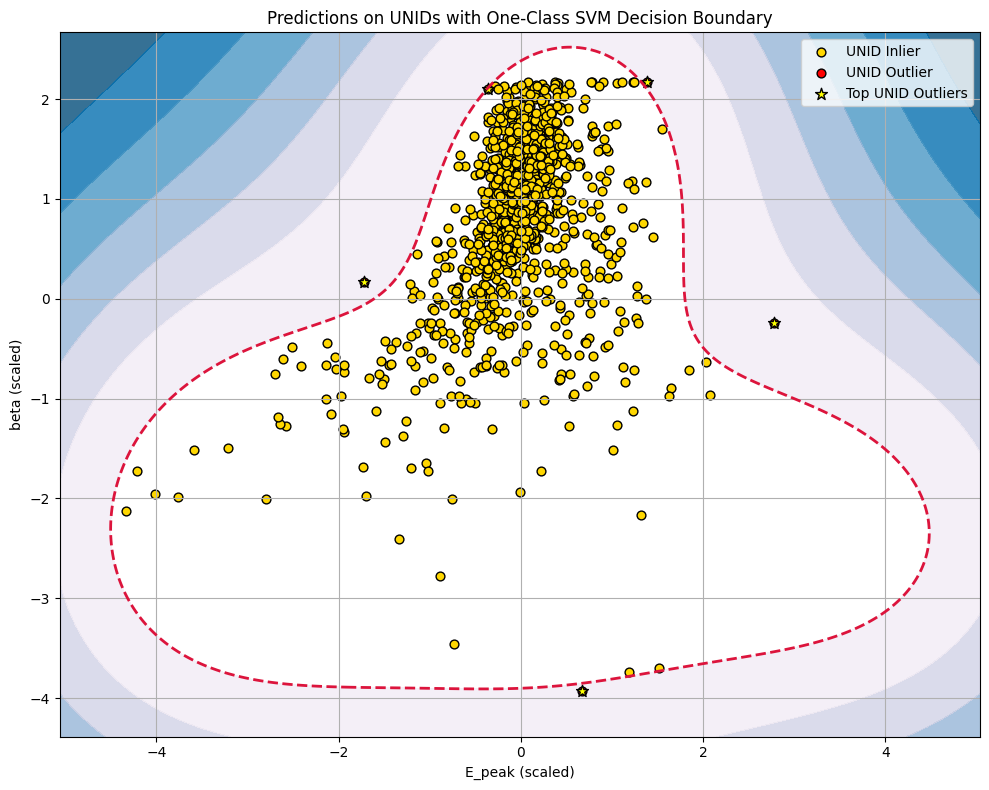

In [1056]:
# Create meshgrid (with correct feature order: [beta, E_peak])
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5, 300),  # E_peak
    np.linspace(X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5, 300)   # beta
)

grid = np.c_[xx.ravel(), yy.ravel()]
Z = final_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

preds_unids = final_model.predict(X_unids_scaled)
inliers = X_unids_scaled[preds_unids == 1]
outliers = X_unids_scaled[preds_unids == -1]

plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', s=40, label='UNID Inlier')
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', s=40, label='UNID Outlier')

# Highlight most anomalous UNIDs using their lowest decision score:
decision_scores = final_model.decision_function(X_unids_scaled)
# Optional: mark top 5 most anomalous
top_anomalies = X_unids_scaled[np.argsort(decision_scores)[:5]]
plt.scatter(top_anomalies[:, 0], top_anomalies[:, 1], c='yellow', edgecolors='black', s=80, label='Top UNID Outliers', marker='*')


# Plot training and test data
# plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], c='skyblue', edgecolors='k', s=40, label='ASTRO (Train)')
# plt.scatter(X_unids_scaled[:, 1], X_unids_scaled[:, 0], c='orchid', edgecolors='k', s=40, label='Test')
# plt.scatter(X_unids_scaled[:, 1], X_unids_scaled[:, 0], c='tomato', edgecolors='k', s=40, label='UNIDs')


plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("Predictions on UNIDs with One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


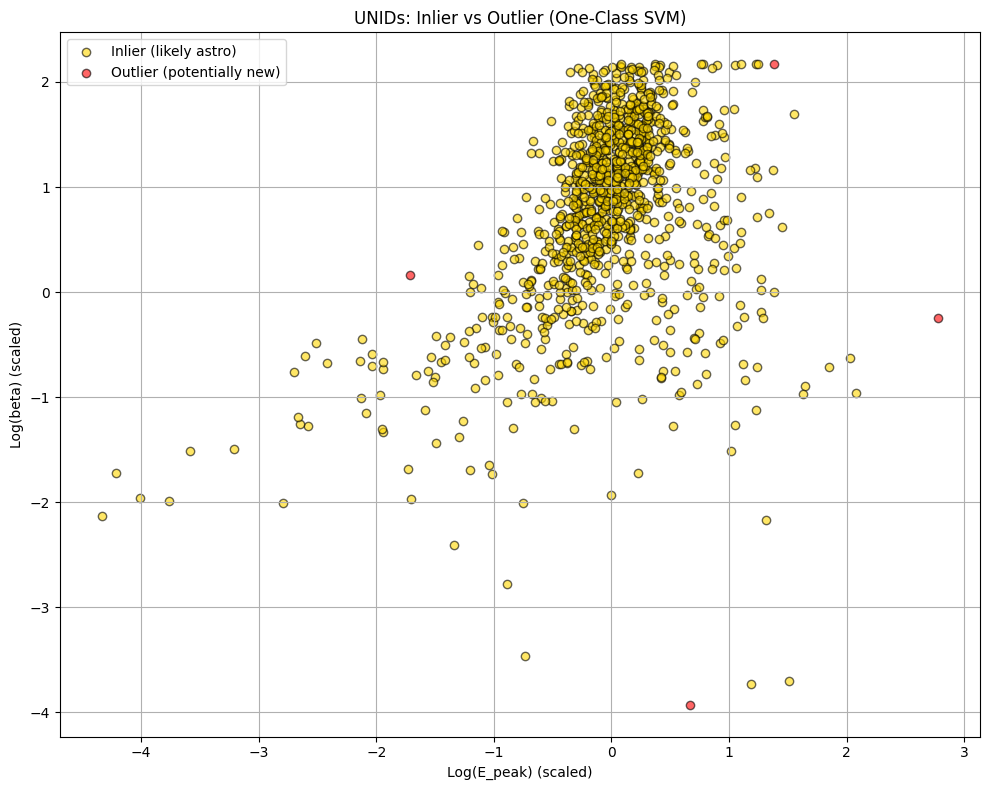

In [1057]:
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

plt.figure(figsize=(10, 8))
plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='Inlier (likely astro)', alpha=0.6)
plt.scatter(outliers[:, 0], outliers[:,1], c='red', edgecolors='k', label='Outlier (potentially new)', alpha=0.6)

plt.xlabel("Log(E_peak) (scaled)")
plt.ylabel("Log(beta) (scaled)")
plt.title("UNIDs: Inlier vs Outlier (One-Class SVM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

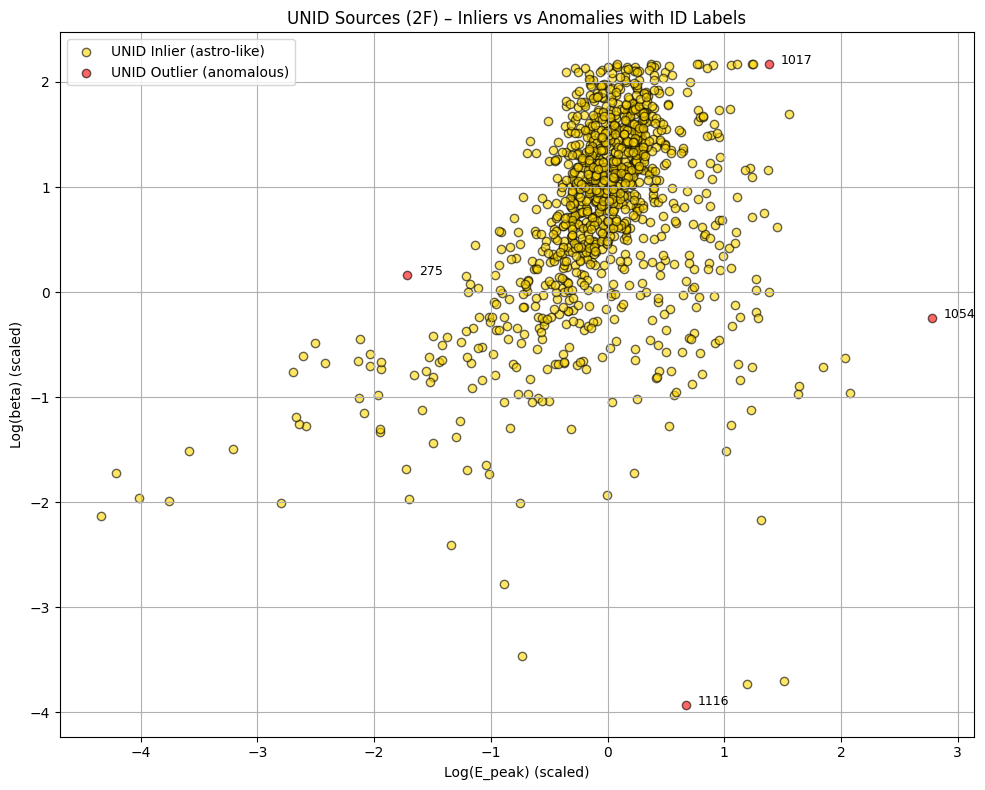

In [1058]:
plt.figure(figsize=(10, 8))

# Inliers and outliers from scaled data
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

# Plot inliers (gold)
plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='UNID Inlier (astro-like)', alpha=0.6)

# Plot outliers (red)
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', label='UNID Outlier (anomalous)', alpha=0.6)

# Annotate top 10 anomalies by ID
for idx in most_anomalous_idx:
    x = X_unids_scaled[idx, 0]  # E_peak (scaled)
    y = X_unids_scaled[idx, 1]  # beta (scaled)
    label = int(df_unids.loc[idx, 'number'])
    plt.text(x + 0.1, y, str(label), color='black', fontsize=9)

# Axis labels and styling
plt.xlabel("Log(E_peak) (scaled)")
plt.ylabel("Log(beta) (scaled)")
plt.title("UNID Sources (2F) – Inliers vs Anomalies with ID Labels")
plt.legend()
plt.grid(True)
plt.tight_layout()

# plt.savefig("../outputs/figures/ocsvm/2F/2F_UNIDs_OneClassSVM_2D_scaled.png", dpi=300, bbox_inches='tight')

plt.show()


## Anomaly Scoring - UNIDs

In [1059]:
# Evaluar cada muestra no identificada con el modelo entrenado
# decision_function devuelve un valor continuo: cuanto más alto, más normal (positivo); cuanto más bajo, más anómalo (negativo)
decision_scores = final_model.decision_function(X_unids_scaled)  # X_unids_scaled = muestras no etiquetadas, ya escaladas

#Predecir si cada punto es inlier (1) o outlier (-1)
unids_preds = final_model.predict(X_unids_scaled)  # 1 = normal, -1 = anomalía


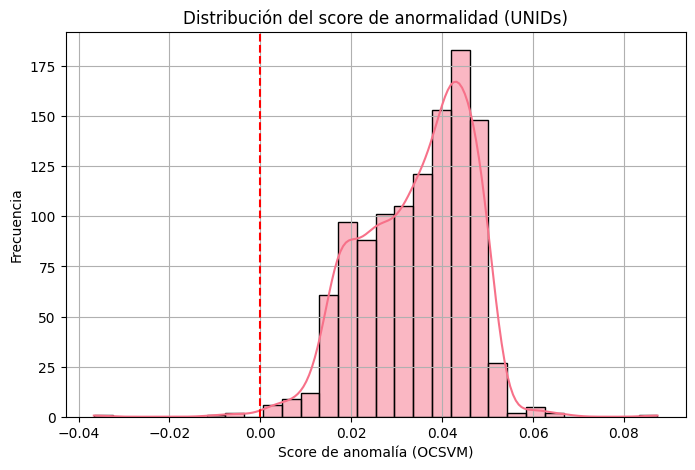

In [1060]:
plt.figure(figsize=(8,5))
sns.histplot(decision_scores, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribución del score de anormalidad (UNIDs)')
plt.xlabel('Score de anomalía (OCSVM)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [1061]:

df_unids['Anomaly_score'] = decision_scores
top_anomalous = df_unids.sort_values('Anomaly_score').head(10)
display(top_anomalous)

,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),number,pred_labels,Anomaly_score
1054,3.469896,-1.037631,0.679664,0.317981,1054,1,-0.036636
275,-2.278140,-0.862013,0.806424,-0.002854,275,1,-0.009451
1116,0.771404,-2.619789,0.747319,1.599337,1116,1,-0.005686
1017,1.682984,-0.000087,0.632690,-1.191027,1017,1,-0.003810
1043,-0.537962,-0.029467,0.735990,-0.559081,1043,0,0.001080
126,1.852297,-2.522879,1.366374,0.721536,126,0,0.002199
592,2.516271,-1.203426,0.782766,0.242840,592,0,0.002587
1111,-1.536062,-0.738737,0.767282,-0.088077,1111,0,0.002763
273,-0.445668,-0.014529,0.761943,-0.530474,273,0,0.003307
564,1.438969,-2.537602,0.865797,1.397940,564,0,0.003314


In [1062]:

# Agregar los resultados al DataFrame original
df_unids["svm_score"] = decision_scores       # Puntaje bruto del modelo (positivo = normal)
df_unids["prediction"] = unids_preds          # Clasificación binaria: inlier o outlier

# Invertimos el score para que valores más altos signifiquen más anomalía
# Esto es útil para poder escalar la puntuación y ordenar más intuitivamente
anom_scores = -decision_scores  # Ahora, valores grandes = más anómalos

# Escalamos los scores de anomalía al rango [0, 100] para facilitar su interpretación
anom_percent = MinMaxScaler(feature_range=(0, 100)).fit_transform(anom_scores.reshape(-1, 1)).flatten()

# Guardamos el puntaje invertido y su porcentaje normalizado en el DataFrame
df_unids["(-)Anomaly_Score"] = anom_scores
df_unids["Anomaly_Rank(%)"] = anom_percent  # 100 = más anómalo, 0 = más normal

# Paso 6: Filtramos solo los puntos predichos como anómalos y los ordenamos por su score más alto
top_anomalies = df_unids[df_unids["prediction"] == -1] \
                    .sort_values(by="Anomaly_Rank(%)", ascending=False) \
                    .head(10)

# Guardamos los índices (puede ser útil si queremos recuperar sus posiciones originales)
most_anomalous_idx = top_anomalies.index

# Paso 7: Guardamos los 10 más anómalos en un archivo
top_anomalies.to_csv("../data/results/ocsvm/2F/unids_most_anomalous_2F.txt", sep="\t", index=False)

# Paso 8: Mostramos en pantalla un resumen de las anomalías detectadas
print("Top Most Anomalous UNID Sources (4F One-Class SVM):")
display(top_anomalies[['number', 'svm_score', 'Anomaly_score', '(-)Anomaly_Score', 'Anomaly_Rank(%)']])

Top Most Anomalous UNID Sources (4F One-Class SVM):


,number,svm_score,Anomaly_score,(-)Anomaly_Score,Anomaly_Rank(%)
1054,1054,-0.036636,-0.036636,0.036636,100.000000
275,275,-0.009451,-0.009451,0.009451,78.078019
1116,1116,-0.005686,-0.005686,0.005686,75.041503
1017,1017,-0.003810,-0.003810,0.003810,73.528997


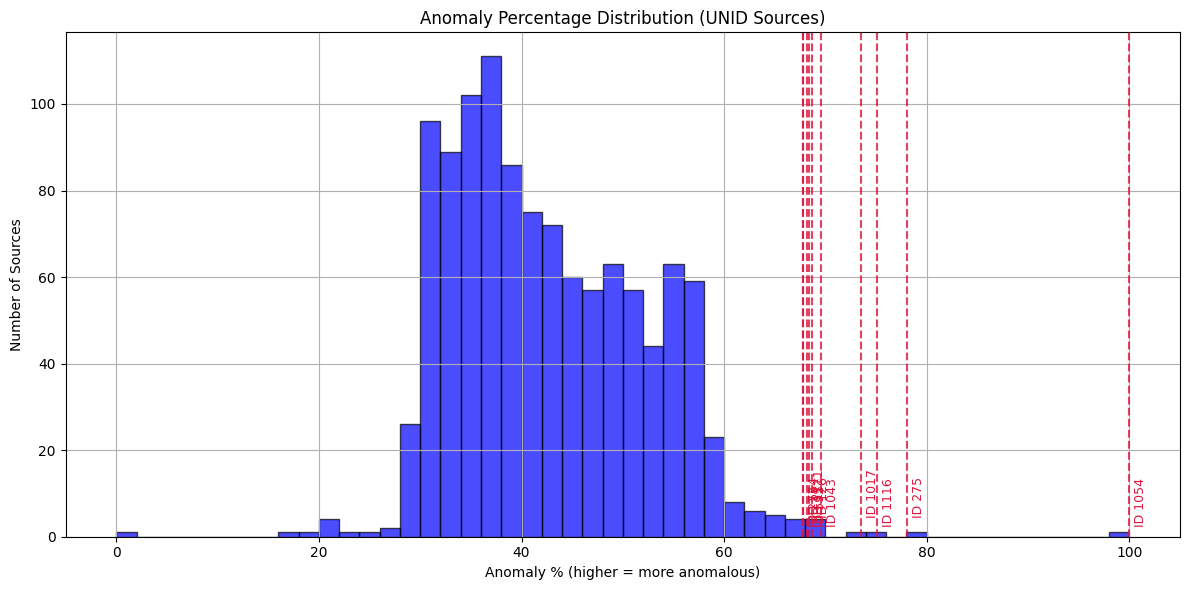

In [1063]:

# Sort anomaly scores and grab top N labels
N = 10
sorted_idx = np.argsort(-anom_percent)  # high anomaly % = more anomalous
top_N_idx = sorted_idx[:N]

top_labels = df_unids.iloc[top_N_idx]['number'].astype(str).values
top_scores = anom_percent[top_N_idx]

plt.figure(figsize=(12, 6))
plt.hist(anom_percent, bins=50, color='blue', edgecolor='k', alpha=0.7)
plt.title("Anomaly Percentage Distribution (UNID Sources)")
plt.xlabel("Anomaly % (higher = more anomalous)")
plt.ylabel("Number of Sources")

for i in range(N):
    x = top_scores[i]
    label = top_labels[i]
    plt.axvline(x, color='crimson', linestyle='--', alpha=0.8)
    plt.text(x + 0.5, 3 + (i % 2) * 2, f"ID {label}", rotation=90, color='crimson', ha='left', fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()


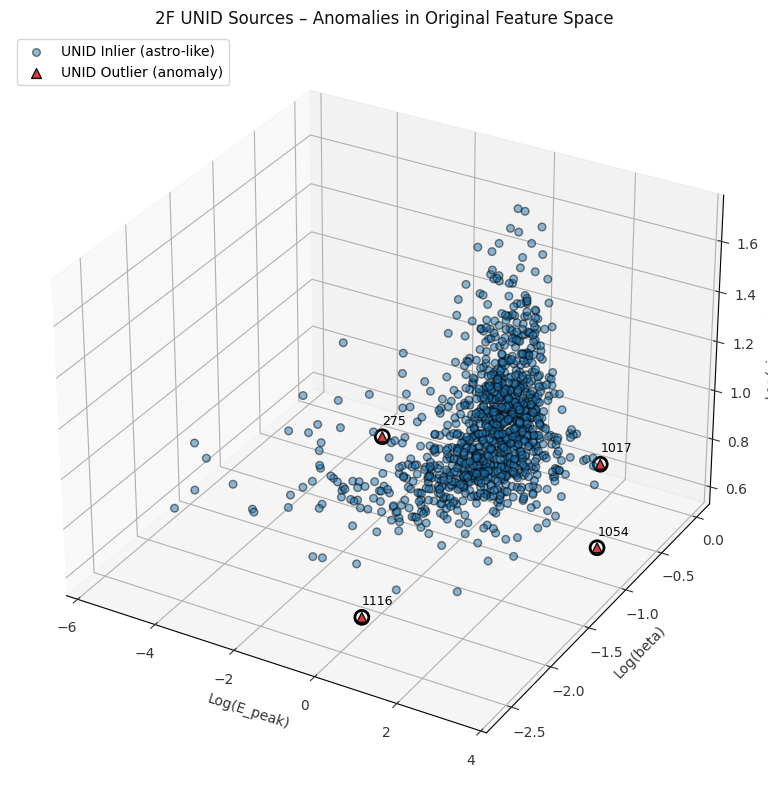

In [1064]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Original/log-transformed values for 3 relevant features
x_vals = df_unids['Log(E_peak)'].values
y_vals = df_unids['Log(beta)'].values
z_vals = df_unids['Log(sigma_det)'].values  # or 'Log(beta_Rel)' for 3F.2

# Use model predictions for coloring
inlier_idx = df_unids['prediction'] == 1
outlier_idx = df_unids['prediction'] == -1

# Inliers
ax.scatter(
    x_vals[inlier_idx], y_vals[inlier_idx], z_vals[inlier_idx],
    c='#1f77b4', edgecolor='k', s=30, label='UNID Inlier (astro-like)', alpha=0.5
)

# Outliers
ax.scatter(
    x_vals[outlier_idx], y_vals[outlier_idx], z_vals[outlier_idx],
    c='#d62728', marker='^', edgecolor='k', s=50, label='UNID Outlier (anomaly)', alpha=0.9
)

# Annotate top anomalies
top_anomalies = df_unids[df_unids['prediction'] == -1].sort_values('Anomaly_Rank(%)', ascending=False).head(10)
for idx in top_anomalies.index:
    ax.scatter(
        x_vals[idx], y_vals[idx], z_vals[idx],
        facecolors='none', edgecolors='black', linewidths=2, s=100
    )
    ax.text(
        x_vals[idx], y_vals[idx], z_vals[idx] + 0.05,
        str(int(df_unids.loc[idx, 'number'])),
        color='black', fontsize=9
    )

ax.set_xlabel('Log(E_peak)')
ax.set_ylabel('Log(beta)')
ax.set_zlabel('Log(sigma_det)')  # or 'Log(beta_Rel)' for 3F.2
ax.set_title("2F UNID Sources – Anomalies in Original Feature Space")
ax.legend(loc='upper left')

ax.tick_params(colors='#333333')
ax.xaxis.label.set_color('#333333')
ax.yaxis.label.set_color('#333333')
ax.zaxis.label.set_color('#333333')
ax.title.set_color('#111111')
ax.grid(color='#aaaaaa', linestyle='--', alpha=0.3)

# plt.savefig("../outputs/figures/ocsvm/2F/2F_UNIDs_OneClassSVM_og.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# Comparar con UNIDs ANN

In [1065]:
from scipy.stats import spearmanr, pearsonr
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [1066]:
# Load and process supervised model predictions
print("Loading supervised model predictions...")

# Load predictions data
unids_DM_std_proba_repeated_kfold = np.genfromtxt('../data/results/ann/2F/unids_DM_std_proba_check_repeated_kfold_2F_21.txt', dtype='str') 
unids_DM_std_proba_data_repeated_kfold = np.asarray(unids_DM_std_proba_repeated_kfold[1::], dtype=float)

print(f"Raw predictions shape: {unids_DM_std_proba_data_repeated_kfold.shape}")

# Get dimensions
# Load unID source data
unids_3F = np.genfromtxt('../data/unids_3F_beta_err_names.txt',dtype='str') 
unids_3F_data = np.asarray(unids_3F[1::,:],dtype=float)
unids_log=np.log10(unids_3F_data[:,[0,1]])
N_unids = unids_log.shape[0]
# N_sample = unids_DM_std_proba_data_repeated_kfold.shape[1] - 1  # CV folds
N_sample = 10

print(f"Number of sources: {N_unids}")
print(f"Number of CV folds: {N_sample}")

Loading supervised model predictions...
Raw predictions shape: (11250, 2)
Number of sources: 1125
Number of CV folds: 10


In [1067]:
# Extract indices and reshape probabilities
unids_number = unids_DM_std_proba_data_repeated_kfold[0:N_unids, 0]
prob_values = unids_DM_std_proba_data_repeated_kfold[:, 1].reshape(N_unids, N_sample)

# Create probability matrix
unids_DM_std_proba_N_sample_repeated_kfold = np.zeros((N_unids, N_sample + 1))
unids_DM_std_proba_N_sample_repeated_kfold[:, 0] = unids_number[:].astype(int)
unids_DM_std_proba_N_sample_repeated_kfold[:, 1:(N_sample + 1)] = prob_values

print(f"Probability matrix shape: {unids_DM_std_proba_N_sample_repeated_kfold.shape}")
print("Sample of probability matrix:")
print(unids_DM_std_proba_N_sample_repeated_kfold[:3, :])

Probability matrix shape: (1125, 11)
Sample of probability matrix:
[[0.00000000e+00 3.11752910e-09 4.73764218e-01 5.80621227e-01
  3.56068135e-01 3.10245987e-01 8.80019118e-13 1.96160781e-11
  5.95317884e-09 3.76347496e-01 1.28108197e-02]
 [1.00000000e+00 5.28285356e-24 9.97549974e-36 4.22869038e-01
  5.65285446e-56 5.44149710e-01 7.55994866e-02 5.08971759e-02
  4.88865364e-04 3.48978122e-30 5.39012525e-01]
 [2.00000000e+00 1.41623503e-64 5.53548811e-14 4.72246326e-01
  7.21383507e-02 7.16678195e-01 9.31223250e-01 1.70914440e-52
  4.70076323e-04 3.83318439e-06 5.23345320e-01]]


In [1068]:
# Extract probability data (excluding index column)
prob_data = unids_DM_std_proba_N_sample_repeated_kfold[:, 1:(N_sample + 1)]

# Calculate statistics across CV folds
unids_mean = np.mean(prob_data, axis=1)
unids_std = np.std(prob_data, axis=1)
unids_median = np.median(prob_data, axis=1)

unids_min = np.min(prob_data, axis=1)
unids_max = np.max(prob_data, axis=1)

unids_q25 = np.percentile(prob_data, 25, axis=1)
unids_q75 = np.percentile(prob_data, 75, axis=1)

print("Supervised model statistics calculated:")
print(f"  Mean probability range: {unids_mean.min():.4f} - {unids_mean.max():.4f}")
print(f"  Standard deviation range: {unids_std.min():.4f} - {unids_std.max():.4f}")

Supervised model statistics calculated:
  Mean probability range: 0.0412 - 0.5137
  Standard deviation range: 0.0758 - 0.3784


In [1069]:
# Create supervised model DataFrame
supervised_df = pd.DataFrame({
    'source_id': unids_number.astype(int),
    'supervised_mean_prob': unids_mean,
    'supervised_std_prob': unids_std,
    'supervised_median_prob': unids_median,
    'supervised_min_prob': unids_min,
    'supervised_max_prob': unids_max,
    'supervised_q25': unids_q25,
    'supervised_q75': unids_q75,
    'supervised_cv_range': unids_max - unids_min,
    'E_peak': unids_3F_data[:, 0],
    'Beta': unids_3F_data[:, 1],
    'log_E_peak': unids_log[:, 0],
    'log_Beta': unids_log[:, 1]
})

print(f"Supervised DataFrame created with {len(supervised_df)} sources")
print("\nSupervised model top 10 candidates:")
display(supervised_df.nlargest(10, 'supervised_mean_prob')[['source_id', 'supervised_mean_prob', 'supervised_std_prob', 'E_peak', 'Beta']].round(4))

Supervised DataFrame created with 1125 sources

Supervised model top 10 candidates:


,source_id,supervised_mean_prob,supervised_std_prob,E_peak,Beta
889,889,0.5137,0.2917,2.0126,0.6167
525,525,0.5053,0.2240,2.6115,0.3131
975,975,0.5032,0.2339,0.5083,0.3575
967,967,0.4969,0.1965,0.7674,0.2984
996,996,0.4941,0.1026,0.5916,0.2197
439,439,0.4768,0.2634,3.5231,0.4710
933,933,0.4707,0.1058,0.4345,0.4125
546,546,0.4689,0.0990,1.2265,0.5375
926,926,0.4675,0.1603,0.3378,0.2123
560,560,0.4590,0.2771,1.4393,0.3499


In [1070]:
# Merge with OCSVM results
print("Merging supervised and OCSVM results...")

# Check available columns in OCSVM DataFrame
print("OCSVM DataFrame columns:", df_unids.columns.tolist())

# Merge datasets - adjust merge column as needed
if 'number' in df_unids.columns:
    combined_df = pd.merge(supervised_df, df_unids, left_on='source_id', right_on='number', how='inner')
elif 'source_id' in df_unids.columns:
    combined_df = pd.merge(supervised_df, df_unids, on='source_id', how='inner')
else:
    # If no common key, merge by index (assuming same order)
    print("Warning: No common identifier found, merging by index")
    combined_df = pd.concat([supervised_df.reset_index(drop=True), 
                           df_unids.reset_index(drop=True)], axis=1)

print(f"Combined dataset shape: {combined_df.shape}")
print(f"Combined dataset columns: {combined_df.columns.tolist()}")


Merging supervised and OCSVM results...
OCSVM DataFrame columns: ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)', 'number', 'pred_labels', 'Anomaly_score', 'svm_score', 'prediction', '(-)Anomaly_Score', 'Anomaly_Rank(%)']
Combined dataset shape: (1125, 24)
Combined dataset columns: ['source_id', 'supervised_mean_prob', 'supervised_std_prob', 'supervised_median_prob', 'supervised_min_prob', 'supervised_max_prob', 'supervised_q25', 'supervised_q75', 'supervised_cv_range', 'E_peak', 'Beta', 'log_E_peak', 'log_Beta', 'Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)', 'number', 'pred_labels', 'Anomaly_score', 'svm_score', 'prediction', '(-)Anomaly_Score', 'Anomaly_Rank(%)']


In [1071]:
# Calculate model correlations
print("Calculating model correlations...")

# Check if required columns exist
required_cols = ['supervised_mean_prob', 'Anomaly_Rank(%)']
missing_cols = [col for col in required_cols if col not in combined_df.columns]

if missing_cols:
    print(f"Error: Missing columns {missing_cols}")
    print("Available columns:", combined_df.columns.tolist())
else:
    # Calculate correlations

    # Correlación de Pearson: Mide si hay una relación lineal entre los dos modelos
    corr_pearson, p_pearson = pearsonr(combined_df['supervised_mean_prob'], 
                                      combined_df['Anomaly_Rank(%)'])
    
    # Correlación de Spearman: Mide si hay una relación de orden (si uno sube, el otro también)
    corr_spearman, p_spearman = spearmanr(combined_df['supervised_mean_prob'], 
                                         combined_df['Anomaly_Rank(%)'])
    
    """ CÓMO INTERPRETAR LA CORRELACIÓN:
        +1: Correlación perfecta positiva (cuando uno sube, el otro también)
        0: No hay relación
        -1: Correlación perfecta negativa (cuando uno sube, el otro baja)

        Correlación baja (0 a +0.3): Los modelos ven cosas diferentes, pueden ser complementarios
    """
    
    print(f"\nMODEL CORRELATION RESULTS:")
    print(f"  Pearson correlation: {corr_pearson:.4f} (p-value: {p_pearson:.4e})")
    print(f"  Spearman correlation: {corr_spearman:.4f} (p-value: {p_spearman:.4e})")
    
    # Interpretation
    if abs(corr_spearman) > 0.7:
        print("  → Strong correlation between models")
    elif abs(corr_spearman) > 0.4:
        print("  → Moderate correlation between models")
    else:
        print("  → Weak correlation between models")

Calculating model correlations...

MODEL CORRELATION RESULTS:
  Pearson correlation: -0.0689 (p-value: 2.0883e-02)
  Spearman correlation: -0.0541 (p-value: 6.9921e-02)
  → Weak correlation between models


In [1072]:
# ANALISIS DE SOLAPAMIENTO
# Analyze top candidates overlap
top_n = 20
print(f"\nAnalyzing top {top_n} candidates from each model...")

# Get top candidates from each model
top_supervised = combined_df.nlargest(top_n, 'supervised_mean_prob')
top_anomalous = combined_df.nlargest(top_n, 'Anomaly_Rank(%)')

# Find overlap
supervised_ids = set(top_supervised.index)
anomaly_ids = set(top_anomalous.index)
overlap_ids = supervised_ids.intersection(anomaly_ids)

# Calculate overlap metrics
total_overlap = len(overlap_ids)
overlap_percentage = total_overlap / top_n * 100 # Porcentaje de solapamiento: ¿Qué porcentaje de los top 20 de cada modelo coinciden?
jaccard_index = total_overlap / len(supervised_ids.union(anomaly_ids)) # Índice de Jaccard: Una medida más rigurosa de similitud entre conjuntos

""" 
    Solapamiento 80-100%: Los modelos están muy de acuerdo
    Solapamiento 50-80%: Acuerdo moderado
    Solapamiento <50%: Los modelos ven cosas muy diferentes
"""

print(f"\nTOP {top_n} CANDIDATES OVERLAP:")
print(f"  Sources in both top {top_n}: {total_overlap}")
print(f"  Overlap percentage: {overlap_percentage:.1f}%")
print(f"  Jaccard similarity index: {jaccard_index:.4f}")

# Show overlapping candidates
if total_overlap > 0:
    overlap_sources = combined_df.loc[list(overlap_ids)]
    print(f"\nCONSENSUS CANDIDATES (in both top {top_n}):")
    display_cols = ['source_id', 'supervised_mean_prob', 'Anomaly_Rank(%)', 'F_peak', 'Beta']
    available_cols = [col for col in display_cols if col in overlap_sources.columns]
    display(overlap_sources[available_cols].round(4))



Analyzing top 20 candidates from each model...

TOP 20 CANDIDATES OVERLAP:
  Sources in both top 20: 0
  Overlap percentage: 0.0%
  Jaccard similarity index: 0.0000


In [1073]:
# Create consensus ranking
print("Creating consensus ranking...")

# Normalize scores to [0, 1] range
supervised_norm = MinMaxScaler().fit_transform(
    combined_df['supervised_mean_prob'].values.reshape(-1, 1)
).flatten()

ocsvm_norm = combined_df['Anomaly_Rank(%)'] / 100

# Create weighted consensus score (adjust weights as needed)
""" PUNTUACIÓN DE CONSENSO:
    - Combina ambos modelos en una sola puntuación
    - Los pesos (0.6 y 0.4) indican cuánto confías en cada modelo

    NOS DA:
    - Candidatos robustos: Fuentes que ambos modelos consideran interesantes
    - Ranking único: Una lista ordenada combinando ambos enfoques
"""
weights = {'supervised': 0.5, 'ocsvm': 0.5}
consensus_score = (weights['supervised'] * supervised_norm + 
                  weights['ocsvm'] * ocsvm_norm)

# Add consensus columns to DataFrame
combined_df['supervised_norm'] = supervised_norm
combined_df['ocsvm_norm'] = ocsvm_norm
combined_df['consensus_score'] = consensus_score
combined_df['consensus_rank'] = combined_df['consensus_score'].rank(ascending=False, method='dense')

print(f"Consensus ranking created with weights: {weights}")
print(f"Consensus score range: {consensus_score.min():.4f} - {consensus_score.max():.4f}")


Creating consensus ranking...
Consensus ranking created with weights: {'supervised': 0.5, 'ocsvm': 0.5}
Consensus score range: 0.2028 - 0.8003


In [1074]:
# Display top consensus candidates
print("\\nTOP 15 CONSENSUS DARK MATTER CANDIDATES:")
print("="*80)

# Sort by consensus score and display
consensus_top = combined_df.sort_values('consensus_score', ascending=False)

display_cols = ['source_id', 'consensus_rank', 'consensus_score', 
               'supervised_mean_prob', 'supervised_std_prob', 
               'Anomaly_Rank(%)', 'E_peak', 'Beta']
available_display_cols = [col for col in display_cols if col in consensus_top.columns]

display(consensus_top[available_display_cols].head(15).round(4))


\nTOP 15 CONSENSUS DARK MATTER CANDIDATES:


,source_id,consensus_rank,consensus_score,supervised_mean_prob,supervised_std_prob,Anomaly_Rank(%),E_peak,Beta
1054,1054,1.0,0.8003,0.3250,0.1723,100.0000,2950.5000,0.0917
888,888,2.0,0.7125,0.4491,0.2217,56.1637,0.4799,0.0567
577,577,3.0,0.7123,0.4540,0.1793,55.1003,0.0317,0.0689
214,214,4.0,0.7120,0.4500,0.2642,55.8759,34.9870,0.1322
987,987,5.0,0.7104,0.4374,0.2315,58.2175,0.0446,0.0922
1010,1010,6.0,0.7103,0.4490,0.2736,55.7508,58.7180,0.2163
583,583,7.0,0.7069,0.4319,0.2505,58.6864,0.0716,0.1600
517,517,8.0,0.6878,0.4491,0.1929,51.2233,1.1622,0.1021
663,663,9.0,0.6876,0.4222,0.2640,56.8762,0.0645,0.0851
996,996,10.0,0.6838,0.4941,0.1026,40.8999,0.5916,0.2197


Creating comparison visualizations...


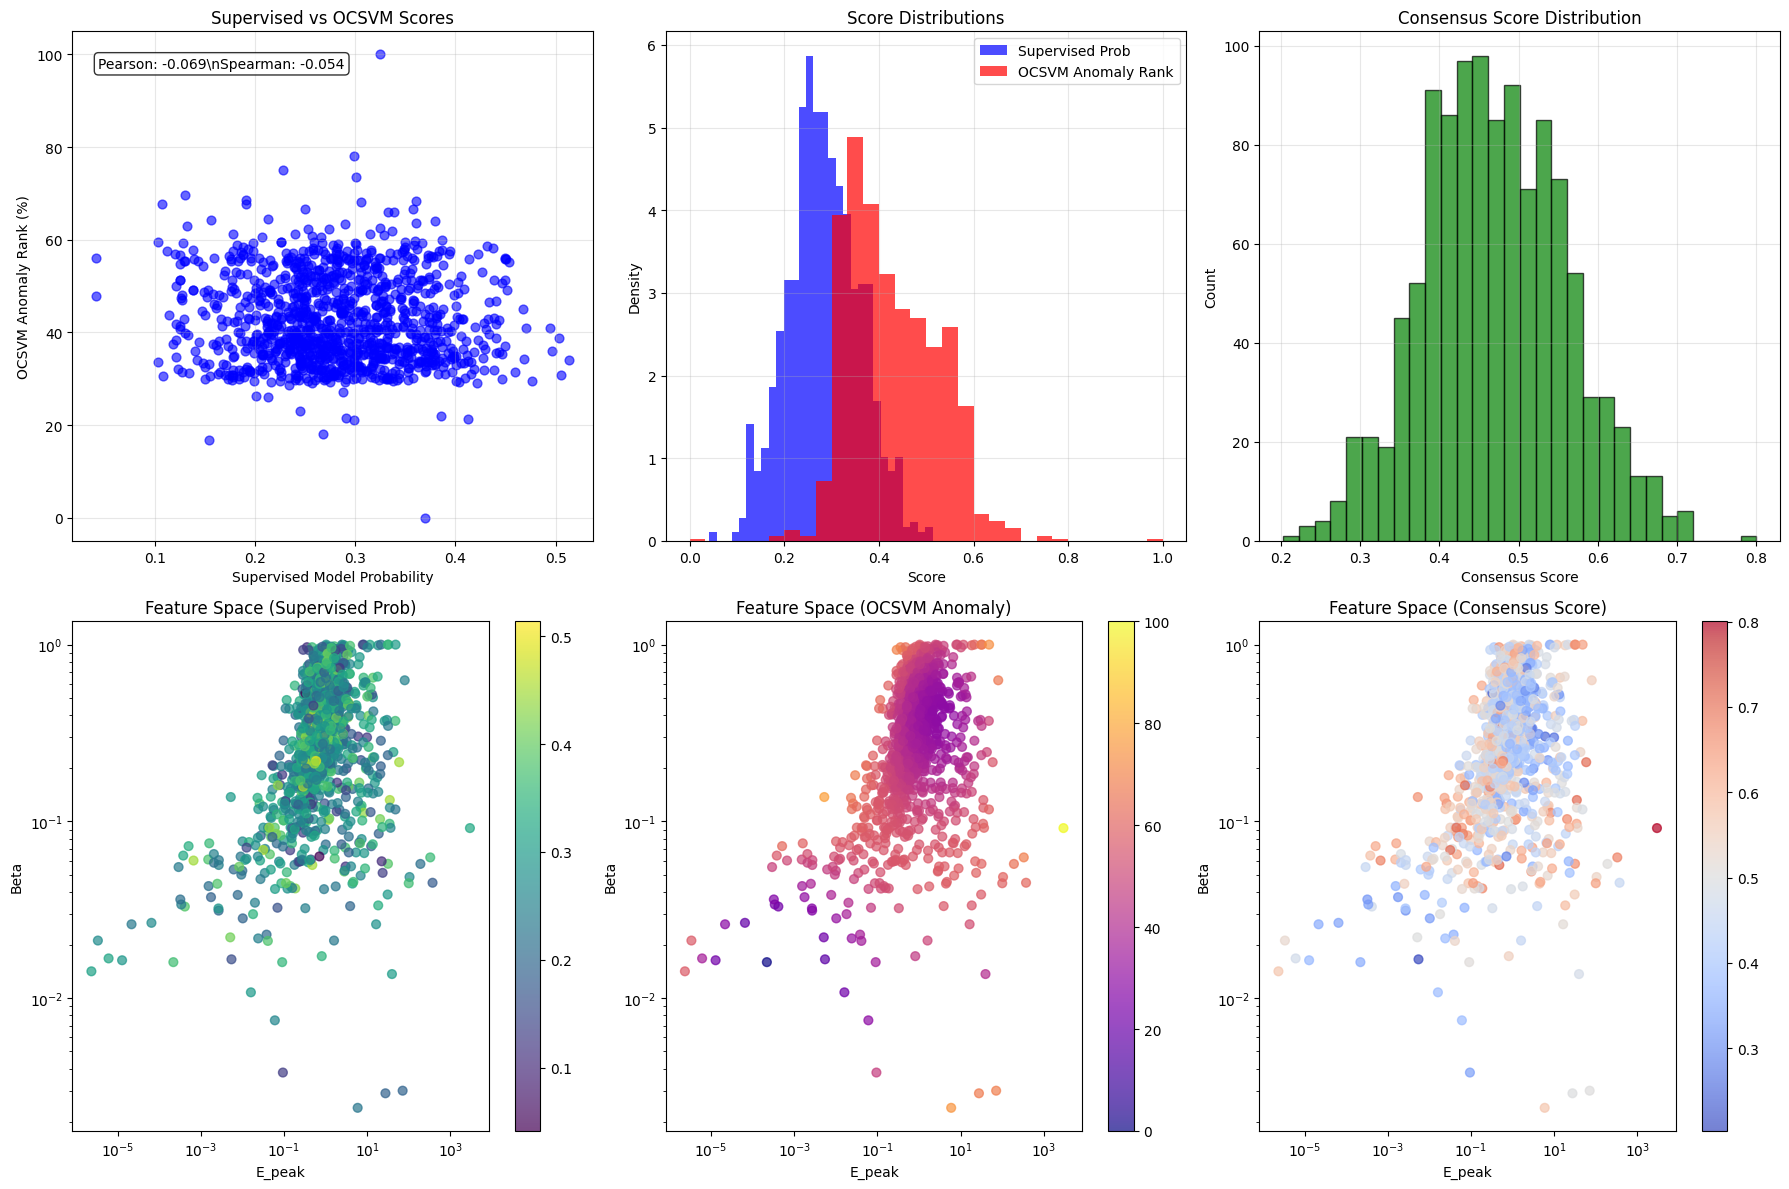

In [1075]:
# Create comparison visualizations
print("Creating comparison visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Scatter plot: Supervised prob vs Anomaly rank
axes[0, 0].scatter(combined_df['supervised_mean_prob'], 
                  combined_df['Anomaly_Rank(%)'], 
                  alpha=0.6, s=40, c='blue')
axes[0, 0].set_xlabel('Supervised Model Probability')
axes[0, 0].set_ylabel('OCSVM Anomaly Rank (%)')
axes[0, 0].set_title('Supervised vs OCSVM Scores')
axes[0, 0].grid(True, alpha=0.3)

# Add correlation text
axes[0, 0].text(0.05, 0.95, 
               f"Pearson: {corr_pearson:.3f}\\nSpearman: {corr_spearman:.3f}",
               transform=axes[0, 0].transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Distribution comparison
axes[0, 1].hist(combined_df['supervised_mean_prob'], bins=30, alpha=0.7, 
               label='Supervised Prob', density=True, color='blue')
axes[0, 1].hist(combined_df['Anomaly_Rank(%)']/100, bins=30, alpha=0.7, 
               label='OCSVM Anomaly Rank', density=True, color='red')
axes[0, 1].set_xlabel('Score')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Score Distributions')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Consensus score distribution
axes[0, 2].hist(combined_df['consensus_score'], bins=30, alpha=0.7, 
               color='green', edgecolor='black')
axes[0, 2].set_xlabel('Consensus Score')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Consensus Score Distribution')
axes[0, 2].grid(True, alpha=0.3)

# 4. Feature space with supervised model coloring
scatter1 = axes[1, 0].scatter(combined_df['E_peak'], combined_df['Beta'], 
                            c=combined_df['supervised_mean_prob'], 
                            cmap='viridis', alpha=0.7, s=40)
axes[1, 0].set_xlabel('E_peak')
axes[1, 0].set_ylabel('Beta')
axes[1, 0].set_title('Feature Space (Supervised Prob)')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
plt.colorbar(scatter1, ax=axes[1, 0])

# 5. Feature space with OCSVM colorin
scatter2 = axes[1, 1].scatter(combined_df['E_peak'], combined_df['Beta'], 
                            c=combined_df['Anomaly_Rank(%)'], 
                            cmap='plasma', alpha=0.7, s=40)
axes[1, 1].set_xlabel('E_peak')
axes[1, 1].set_ylabel('Beta')
axes[1, 1].set_title('Feature Space (OCSVM Anomaly)')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
plt.colorbar(scatter2, ax=axes[1, 1])

# 6. Feature space with consensus coloring
scatter3 = axes[1, 2].scatter(combined_df['E_peak'], combined_df['Beta'], 
                            c=combined_df['consensus_score'], 
                            cmap='coolwarm', alpha=0.7, s=40)
axes[1, 2].set_xlabel('E_peak')
axes[1, 2].set_ylabel('Beta')
axes[1, 2].set_title('Feature Space (Consensus Score)')
axes[1, 2].set_xscale('log')
axes[1, 2].set_yscale('log')
plt.colorbar(scatter3, ax=axes[1, 2])

plt.tight_layout()
plt.show()



Analyzing model agreement across score ranges...

Model Agreement Matrix:
(Rows: Supervised Model, Columns: OCSVM)


Anomaly_Rank(%),Low,Med-Low,Med,Med-High,High,All
supervised_mean_prob,,,,,,
Low,0,10,21,3,0,34
Med-Low,1,102,115,7,0,225
Med,1,248,278,12,0,539
Med-High,1,137,135,8,1,282
High,0,21,24,0,0,45
All,3,518,573,30,1,1125


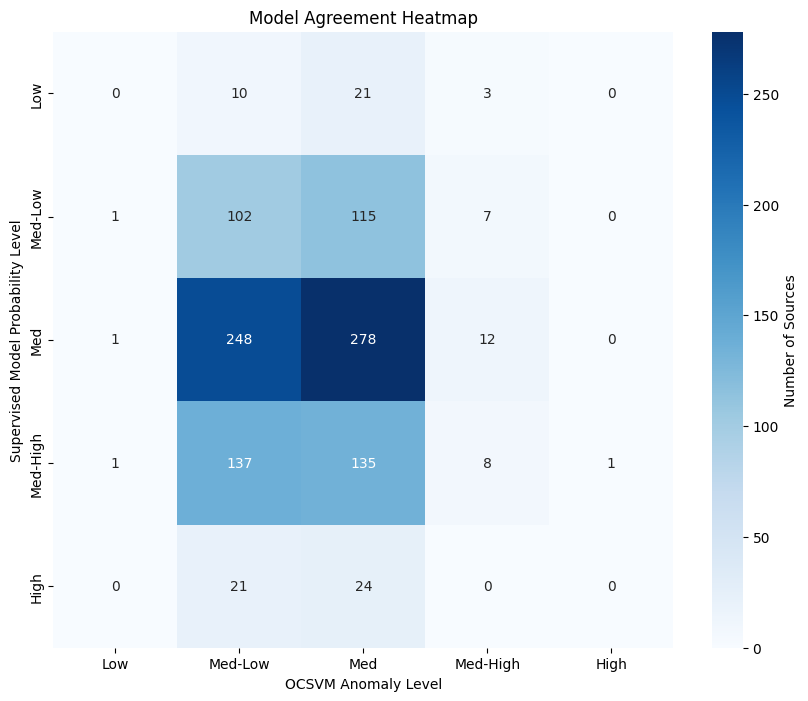

In [1076]:
#  Model agreement analysis
print("\nAnalyzing model agreement across score ranges...")

# Create score bins for agreement analysis
supervised_bins = pd.cut(combined_df['supervised_mean_prob'], 
                        bins=5, labels=['Low', 'Med-Low', 'Med', 'Med-High', 'High'])
anomaly_bins = pd.cut(combined_df['Anomaly_Rank(%)'], 
                     bins=5, labels=['Low', 'Med-Low', 'Med', 'Med-High', 'High'])

# Create agreement matrix
""" 
MATRIZ DE ACUERDO:

    * Ve dónde están de acuerdo los modelos según rangos de puntuación
    * Identifica patrones de desacuerdo

    - Filas: Modelos supervisados
    - Columnas: OCSVM
    - Celdas: Número de fuentes en cada combinación de categorías

    + Diagonal alta: Los modelos están de acuerdo
    + Valores dispersos: Los modelos ven cosas diferentes
    + Esquinas opuestas: Desacuerdo total
"""
agreement_matrix = pd.crosstab(supervised_bins, anomaly_bins, margins=True)
print("\nModel Agreement Matrix:")
print("(Rows: Supervised Model, Columns: OCSVM)")
display(agreement_matrix)

# Plot agreement heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(agreement_matrix.iloc[:-1, :-1], annot=True, fmt='d', 
            cmap='Blues', cbar_kws={'label': 'Number of Sources'})
plt.xlabel('OCSVM Anomaly Level')
plt.ylabel('Supervised Model Probability Level')
plt.title('Model Agreement Heatmap')
plt.show()


In [1077]:
# Summary statistics and final report
print("\n" + "="*80)
print("DARK MATTER CANDIDATE MODEL COMPARISON SUMMARY")
print("="*80)

print(f"\nDATASET OVERVIEW:")
print(f"  Total sources analyzed: {len(combined_df)}")
print(f"  Supervised model probability range: {combined_df['supervised_mean_prob'].min():.4f} - {combined_df['supervised_mean_prob'].max():.4f}")
print(f"  OCSVM anomaly rank range: {combined_df['Anomaly_Rank(%)'].min():.1f}% - {combined_df['Anomaly_Rank(%)'].max():.1f}%")
print(f"  Consensus score range: {combined_df['consensus_score'].min():.4f} - {combined_df['consensus_score'].max():.4f}")

print(f"\nMODEL PERFORMANCE:")
print(f"  Cross-validation folds used: {N_sample}")
print(f"  Mean supervised model uncertainty: {combined_df['supervised_std_prob'].mean():.4f}")
print(f"  Sources with high confidence (>90%): {sum(combined_df['supervised_mean_prob'] > 0.9)}")
print(f"  Sources with low uncertainty (<10%): {sum(combined_df['supervised_std_prob'] < 0.1)}")

print(f"\nMODEL AGREEMENT:")
print(f"  Pearson correlation: {corr_pearson:.4f}")
print(f"  Spearman correlation: {corr_spearman:.4f}")
print(f"  Top {top_n} overlap: {total_overlap} sources ({overlap_percentage:.1f}%)")
print(f"  Jaccard similarity: {jaccard_index:.4f}")

# Identify most promising candidates
high_consensus = combined_df[combined_df['consensus_score'] > 0.8]
print(f"\nHIGH-CONFIDENCE CONSENSUS CANDIDATES:")
print(f"  Sources with consensus score >0.8: {len(high_consensus)}")

if len(high_consensus) > 0:
    print("\nTop 5 highest consensus candidates:")
    top_consensus_cols = ['source_id', 'consensus_score', 'supervised_mean_prob', 'Anomaly_Rank(%)']
    available_consensus_cols = [col for col in top_consensus_cols if col in high_consensus.columns]
    display(high_consensus[available_consensus_cols].head().round(4))



DARK MATTER CANDIDATE MODEL COMPARISON SUMMARY

DATASET OVERVIEW:
  Total sources analyzed: 1125
  Supervised model probability range: 0.0412 - 0.5137
  OCSVM anomaly rank range: 0.0% - 100.0%
  Consensus score range: 0.2028 - 0.8003

MODEL PERFORMANCE:
  Cross-validation folds used: 10
  Mean supervised model uncertainty: 0.2243
  Sources with high confidence (>90%): 0
  Sources with low uncertainty (<10%): 9

MODEL AGREEMENT:
  Pearson correlation: -0.0689
  Spearman correlation: -0.0541
  Top 20 overlap: 0 sources (0.0%)
  Jaccard similarity: 0.0000

HIGH-CONFIDENCE CONSENSUS CANDIDATES:
  Sources with consensus score >0.8: 1

Top 5 highest consensus candidates:


,source_id,consensus_score,supervised_mean_prob,Anomaly_Rank(%)
1054,1054,0.8003,0.325,100.0
